# Q1. Canny Edge Detector

### Noise Reduction

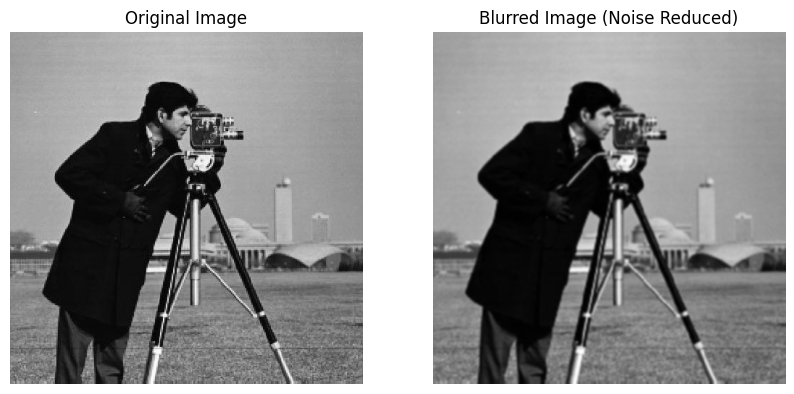

In [1]:
import numpy as np
import cv2  
import matplotlib.pyplot as plt  
from scipy import ndimage
from scipy import fftpack

# Load the image using OpenCV
image = cv2.imread("./Images/cameraman.jpeg", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur using OpenCV
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

# Display the original image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display the blurred image 
plt.subplot(1,2,2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image (Noise Reduced)')
plt.axis('off')

plt.show()

### Gradient Calculation

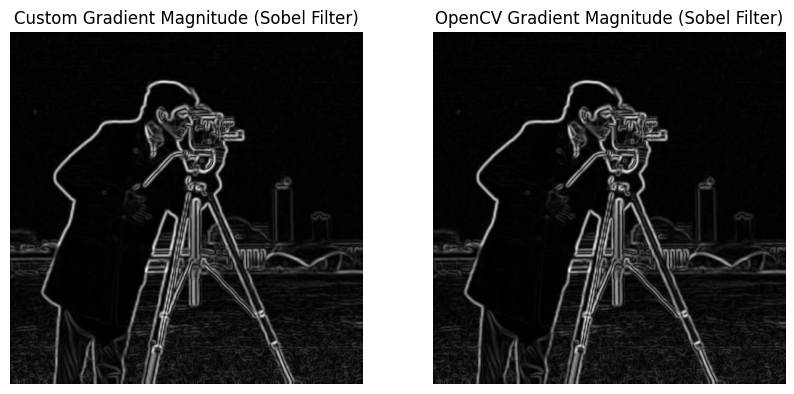

In [2]:
# Function to calculate gradients using Sobel filters
def sobel_filters(img):
    """Applies Sobel filters to compute the gradient magnitude and direction."""
    
    # Define Sobel kernels for x and y direction
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)  # Kernel for gradient in x-direction
    Ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)  # Kernel for gradient in y-direction
    
    # Apply convolution between the image and the Sobel kernels
    Ix = ndimage.convolve(img.astype(np.float64), Kx)  # Gradient in x-direction
    Iy = ndimage.convolve(img.astype(np.float64), Ky)  # Gradient in y-direction
    
    # Compute gradient magnitude
    G = np.hypot(Ix, Iy)  # Equivalent to sqrt(Ix^2 + Iy^2)
    G = G / G.max() * 255 # Normalize to 0-255 for visualization
    
    # Compute gradient direction (angle of edges)
    theta = np.arctan2(Iy, Ix)  # Calculate the angle of the gradient
    
    return (G, theta)

# Apply Sobel filters to the blurred image
gradient_magnitude, gradient_direction = sobel_filters(blurred_image)

# OpenCV Sobel operator
opencv_grad_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
opencv_grad_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
opencv_magnitude = np.sqrt(opencv_grad_x**2 + opencv_grad_y**2)

# Display the gradient magnitudes
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Custom Gradient Magnitude (Sobel Filter)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(opencv_magnitude, cmap='gray')
plt.title('OpenCV Gradient Magnitude (Sobel Filter)')
plt.axis('off')
plt.show()

### Non-Maximum Suppression

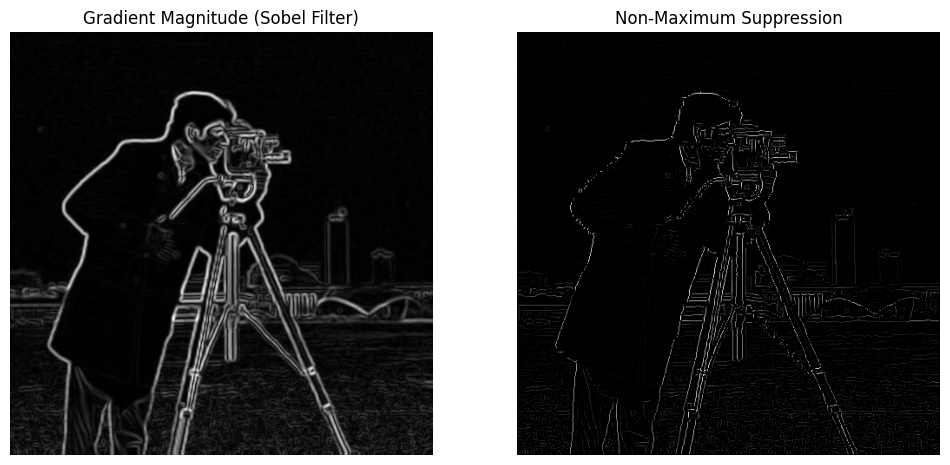

In [3]:
# Non-Maximum Suppression function to thin edges
def non_max_suppression(img, D):
    """Applies Non-Maximum Suppression to thin edges based on gradient direction."""
    
    M, N = img.shape  # Get the dimensions of the image
    Z = np.zeros((M,N), dtype=np.int32)  # Initialize the output array with zeros
    
    # Convert the gradient direction from radians to degrees
    angle = D * 180. / np.pi
    angle[angle < 0] += 180  # Ensure all angles are positive

    # Iterate over the image, ignoring the borders
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255
                
                # Angle 0 degrees (horizontal edge)
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # Angle 45 degrees (diagonal edge: top-left to bottom-right)
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # Angle 90 degrees (vertical edge)
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # Angle 135 degrees (diagonal edge: top-right to bottom-left)
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                # Suppress non-maximum pixels
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass  # Handle border cases by ignoring them
    
    return Z

# Apply Non-Maximum Suppression to the gradient magnitude image
nms_image = non_max_suppression(gradient_magnitude, gradient_direction)

# Plot the results: original gradient magnitude and NMS side-by-side
plt.figure(figsize=(12, 6))

# Original gradient magnitude
plt.subplot(1, 2, 1)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude (Sobel Filter)')
plt.axis('off')

# Gradient magnitude after Non-Maximum Suppression
plt.subplot(1, 2, 2)
plt.imshow(nms_image, cmap='gray')
plt.title('Non-Maximum Suppression')
plt.axis('off')

plt.show()

### Double threshold

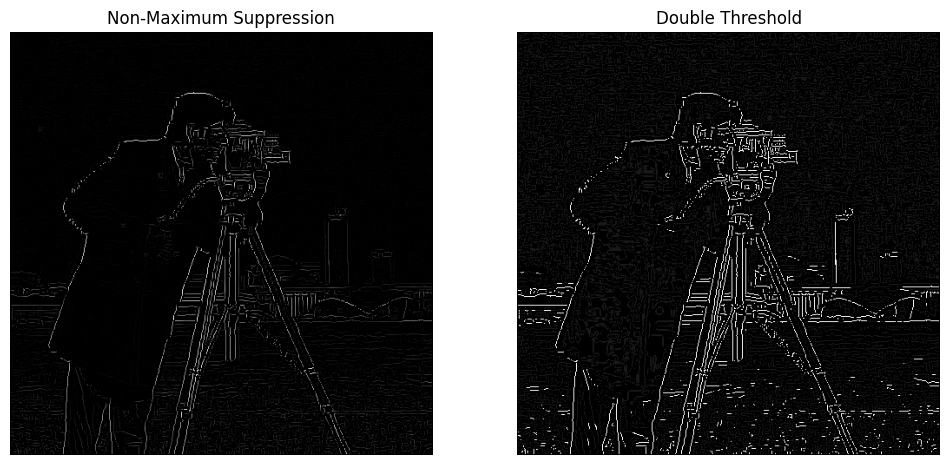

In [4]:
# Double threshold function to classify edges into strong, weak, and non-edges
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    """Applies Double Thresholding to classify pixels into strong, weak, and non-edges."""
    
    # Define the high and low thresholds based on ratios of the maximum value in the image
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    # Initialize the result image with zeros
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)
    
    # Define weak and strong pixel values
    weak = np.int32(25)
    strong = np.int32(255)
    
    # Identify pixels classified as strong, weak, and non-edges
    strong_i, strong_j = np.where(img >= highThreshold)  # Strong edge pixels
    zeros_i, zeros_j = np.where(img < lowThreshold)      # Non-edge pixels
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))  # Weak edge pixels
    
    # Assign strong and weak values to the result image
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

# Apply Double Thresholding to the Non-Maximum Suppression image
threshold_image, weak, strong = threshold(nms_image)

# Plot the results: Non-Maximum Suppression and Double Threshold side-by-side
plt.figure(figsize=(12, 6))

# Non-Maximum Suppression
plt.subplot(1, 2, 1)
plt.imshow(nms_image, cmap='gray')
plt.title('Non-Maximum Suppression')
plt.axis('off')

# Double Threshold
plt.subplot(1, 2, 2)
plt.imshow(threshold_image, cmap='gray')
plt.title('Double Threshold')
plt.axis('off')

plt.show()

### Edge Tracking by Hysteresis

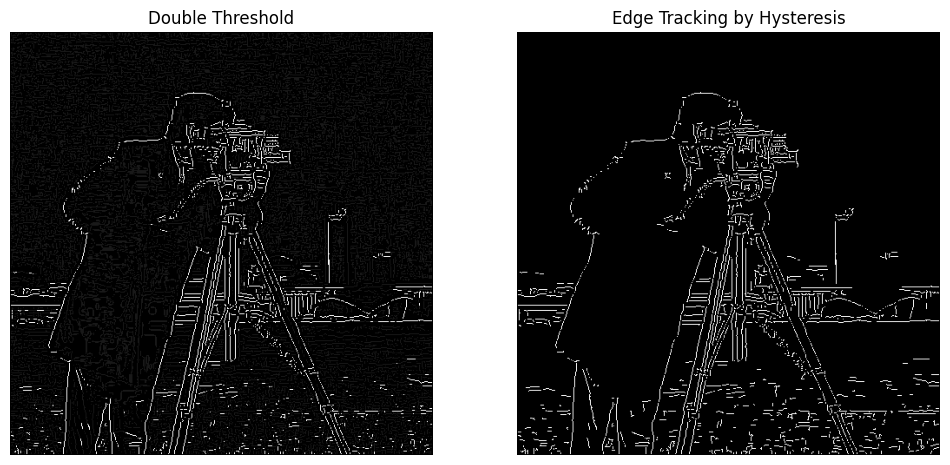

In [5]:
# Edge tracking by hysteresis function to finalize edges
def hysteresis(img, weak, strong=255):
    """Performs edge tracking by hysteresis to finalize edges."""
    
    M, N = img.shape  # Get the image dimensions
    
    # Iterate through the image, avoiding the borders
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                try:
                    # Check the 8-connected neighborhood for strong edges
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong  # Convert weak edge to strong edge
                    else:
                        img[i, j] = 0  # Suppress weak edge if not connected to strong edge
                except IndexError as e:
                    pass
    
    return img

# Apply Hysteresis to track the edges and finalize the result
hysteresis_image = hysteresis(np.copy(threshold_image), weak, strong)

# Plot the results: Double Threshold and Hysteresis side-by-side
plt.figure(figsize=(12, 6))

# Double Threshold result
plt.subplot(1, 2, 1)
plt.imshow(threshold_image, cmap='gray')
plt.title('Double Threshold')
plt.axis('off')

# Hysteresis result
plt.subplot(1, 2, 2)
plt.imshow(hysteresis_image, cmap='gray')
plt.title('Edge Tracking by Hysteresis')
plt.axis('off')

plt.show()

### Comparison between Custom and OpenCV Canny Edge Detection

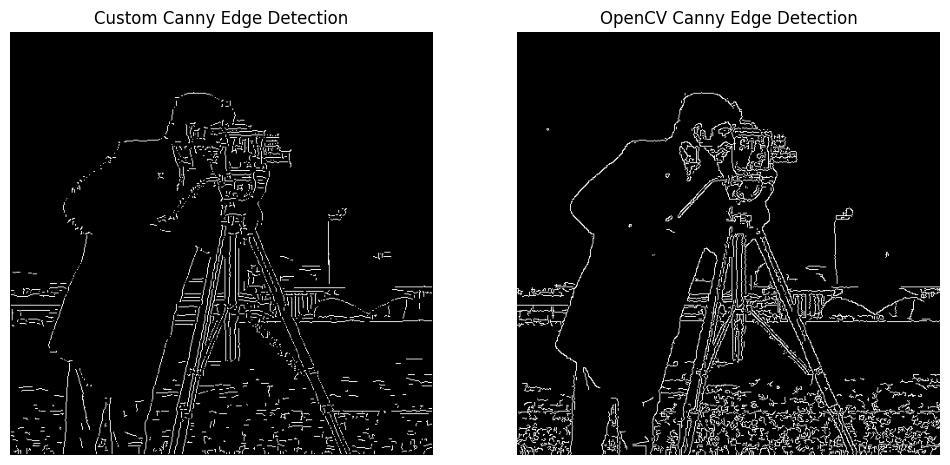

In [6]:
# Apply OpenCV's Canny Edge Detection
opencv_canny_edges = cv2.Canny(image, 100, 200)

# Visualize both results side-by-side for comparison
plt.figure(figsize=(12, 6))

# Custom Canny Edge Detector result
plt.subplot(1, 2, 1)
plt.imshow(hysteresis_image, cmap='gray')
plt.title('Custom Canny Edge Detection')
plt.axis('off')

# OpenCV's Canny Edge Detector result
plt.subplot(1, 2, 2)
plt.imshow(opencv_canny_edges, cmap='gray')
plt.title('OpenCV Canny Edge Detection')
plt.axis('off')

plt.show()

# Q2. Applying Various Blurring Techniques and Resizing Operations on an Image Using OpenCV

### 1. Average Blur

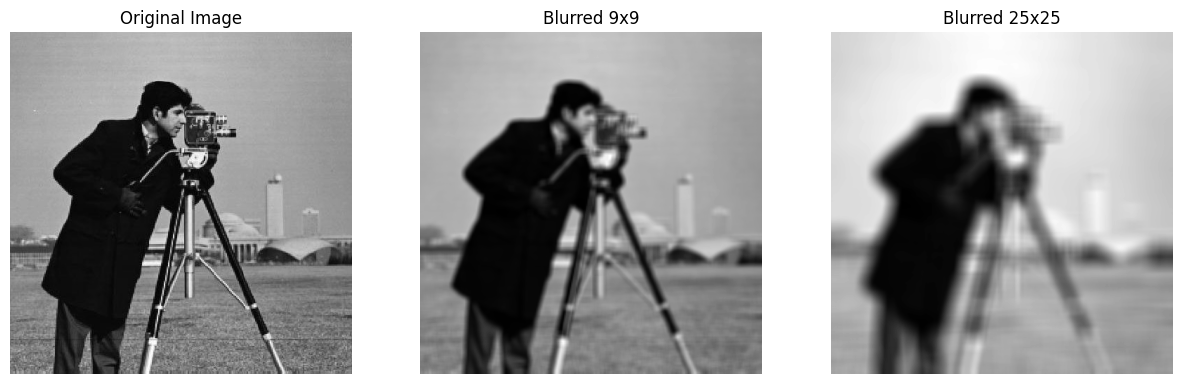

In [7]:
# Apply average blur with kernel sizes 9x9 and 25x25
blurred_9x9 = cv2.blur(image, (9, 9))
blurred_25x25 = cv2.blur(image, (25, 25))

# Display the original and blurred images in a 1x3 grid
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 9x9 blurred image
plt.subplot(1, 3, 2)
plt.imshow(blurred_9x9, cmap='gray')
plt.title('Blurred 9x9')
plt.axis('off')

# 25x25 blurred image
plt.subplot(1, 3, 3)
plt.imshow(blurred_25x25, cmap='gray')
plt.title('Blurred 25x25')
plt.axis('off')

plt.show()

### 2. Gaussian Blur

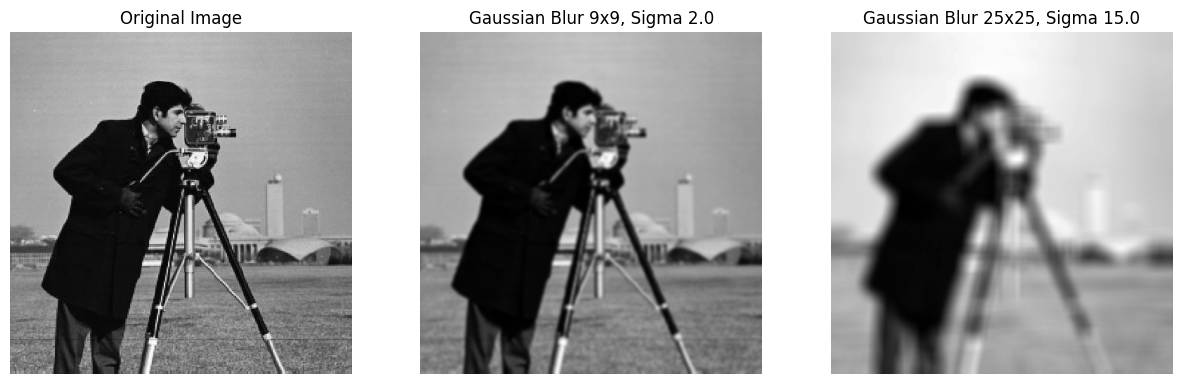

In [8]:
# Apply Gaussian blur with kernel sizes 9x9 and 25x25 with specified sigmas
gaussian_blur_9x9 = cv2.GaussianBlur(image, (9, 9), 2.0)
gaussian_blur_25x25 = cv2.GaussianBlur(image, (25, 25), 15.0)

# Display the original and Gaussian blurred images in a 1x3 grid
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 9x9 Gaussian blurred image
plt.subplot(1, 3, 2)
plt.imshow(gaussian_blur_9x9, cmap='gray')
plt.title('Gaussian Blur 9x9, Sigma 2.0')
plt.axis('off')

# 25x25 Gaussian blurred image
plt.subplot(1, 3, 3)
plt.imshow(gaussian_blur_25x25, cmap='gray')
plt.title('Gaussian Blur 25x25, Sigma 15.0')
plt.axis('off')

plt.show()

### 3. Median Blur

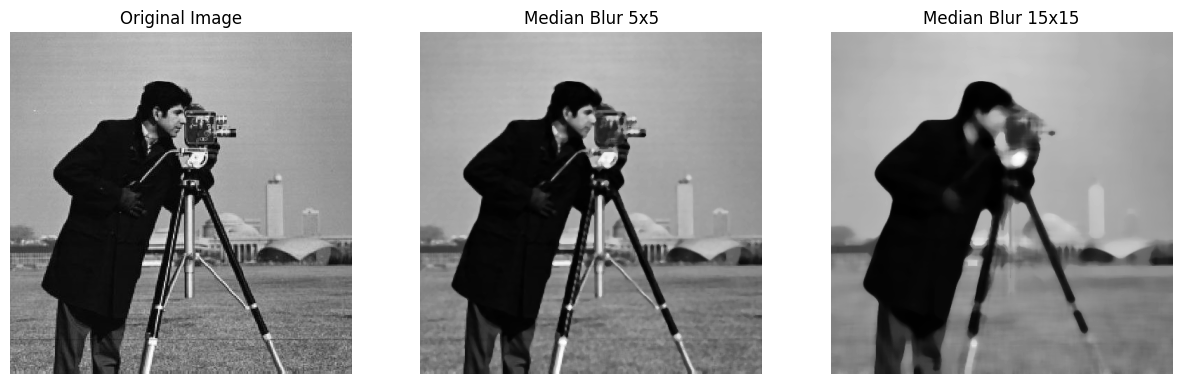

In [9]:
# Apply median blur with kernel sizes 5x5 and 15x15
median_blur_5x5 = cv2.medianBlur(image, 5)
median_blur_15x15 = cv2.medianBlur(image, 15)

# Display the original and median blurred images in a 1x3 grid
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 5x5 Median blurred image
plt.subplot(1, 3, 2)
plt.imshow(median_blur_5x5, cmap='gray')
plt.title('Median Blur 5x5')
plt.axis('off')

# 15x15 Median blurred image
plt.subplot(1, 3, 3)
plt.imshow(median_blur_15x15, cmap='gray')
plt.title('Median Blur 15x15')
plt.axis('off')

plt.show()

### 4. Resizing

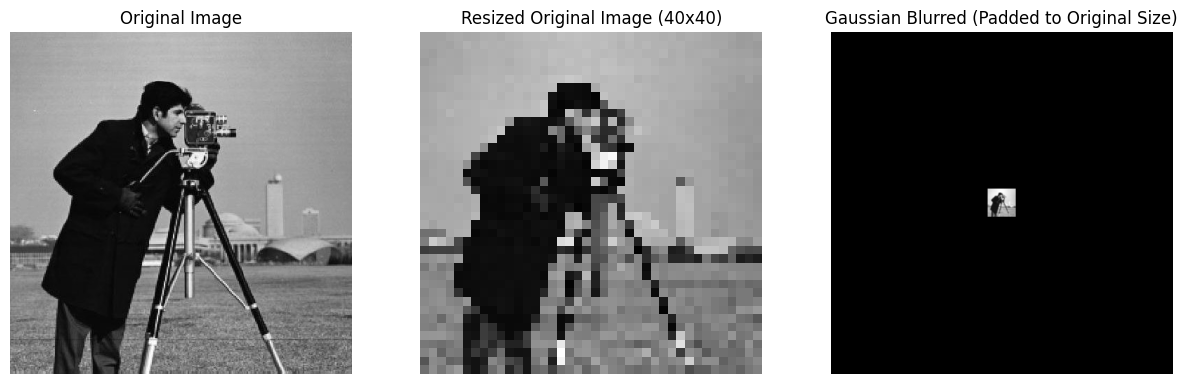

In [10]:
# Resize the Gaussian blurred image (25x25, sigma 15) and the original image to 40x40 pixels
gaussian_blur_resized = cv2.resize(gaussian_blur_25x25, (40, 40))
original_resized = cv2.resize(image, (40, 40))

# Get the size difference between original image and the resized Gaussian blurred image
original_shape = image.shape
pad_y_top = (original_shape[0] - gaussian_blur_resized.shape[0]) // 2
pad_y_bottom = original_shape[0] - gaussian_blur_resized.shape[0] - pad_y_top
pad_x_left = (original_shape[1] - gaussian_blur_resized.shape[1]) // 2
pad_x_right = original_shape[1] - gaussian_blur_resized.shape[1] - pad_x_left

# Apply zero-padding to the resized Gaussian blurred image to make it the same size as the original image
gaussian_padded = cv2.copyMakeBorder(gaussian_blur_resized, pad_y_top, pad_y_bottom, pad_x_left, pad_x_right, cv2.BORDER_CONSTANT, value=0)

# Display the original, resized original, and padded Gaussian blurred image in a 1x3 grid
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Resized original image
plt.subplot(1, 3, 2)
plt.imshow(original_resized, cmap='gray')
plt.title('Resized Original Image (40x40)')
plt.axis('off')

# Padded Gaussian blurred image
plt.subplot(1, 3, 3)
plt.imshow(gaussian_padded, cmap='gray')
plt.title('Gaussian Blurred (Padded to Original Size)')
plt.axis('off')

plt.show()

# Q3. 2D Discrete Fourier Transform

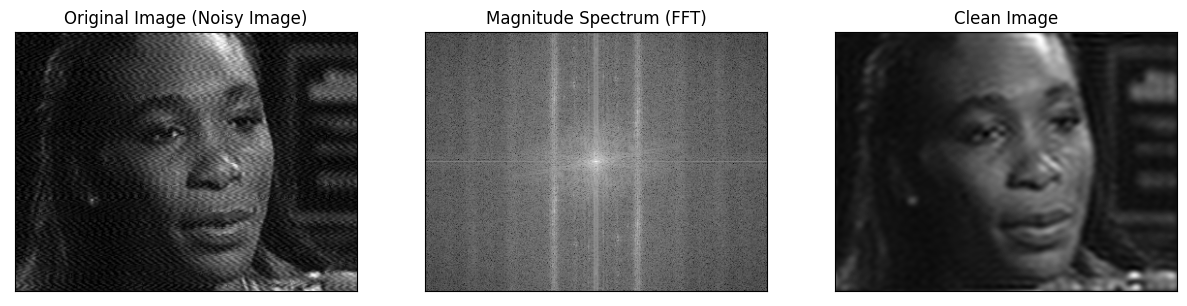

In [11]:
# Load the image
bandnoise = cv2.imread("./Images/bandnoise.png", cv2.IMREAD_GRAYSCALE)

# Compute the 2D Fourier Transform of the image
fft_image = fftpack.fft2(bandnoise)

# Shift the zero-frequency component to the center of the spectrum
fft_shift = fftpack.fftshift(fft_image)

# Create a mask to filter out high-frequency noise
rows, cols = fft_image.shape
crow, ccol = rows//2, cols//2
mask = np.zeros((rows, cols), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# Apply the mask to the Fourier Transform
fft_shift_filtered = fft_shift * mask

# Inverse Fourier Transform to get the denoised image
fft_filtered = fftpack.ifftshift(fft_shift_filtered)
denoised_image = fftpack.ifft2(fft_filtered).real

# Plot the noisy image, the magnitude spectrum, and the cleaned image
plt.figure(figsize=(15, 5))

# Noisy image
plt.subplot(1,3,1)
plt.imshow(bandnoise, cmap='gray')
plt.title('Original Image (Noisy Image)')
plt.xticks([])
plt.yticks([])

# Magnitude spectrum of the Fourier transform
plt.subplot(1,3,2)
plt.imshow(np.log(1 + np.abs(fft_shift)), cmap='gray')
plt.title('Magnitude Spectrum (FFT)')
plt.xticks([])
plt.yticks([])

# Cleaned image after filtering
plt.subplot(1,3,3)
plt.imshow(denoised_image, cmap='gray')
plt.title('Clean Image')
plt.xticks([])
plt.yticks([])
plt.show()